# Continuous Control

---

## Import libraries

In [1]:
#!pip -q install ./python

In [1]:
import torch
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent
from ddpg_agents import Agents
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

### 1. Start the Environment


In [2]:

env = UnityEnvironment(file_name='Reacher_Windows_x86_64_20\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train 20 Agents in the Environment

In [5]:
# env.seed(10)
random_seed = 10
agents = Agents(state_size=state_size, action_size=action_size, random_seed=random_seed)

In [7]:
def ddpg(agent, brain_name, n_episodes=2000, max_t=1000, window_size=100, score_threshold=30.0, print_interval=10):
    """
    Deep Deterministic Policy Gradient (DDPG) training loop.

    Args:
    - agent: the DDPG agent
    - brain_name: the name of the brain associated with the environment
    - n_episodes: maximum number of training episodes (default=2000)
    - max_t: maximum number of timesteps per episode (default=1000)
    - window_size: size of the moving window to calculate the average score (default=100)
    - score_threshold: the average score threshold for considering the environment solved (default=30.0)
    - print_interval: interval for printing the training progress (default=10)

    Returns:
    - scores: list of scores obtained during training

    This function performs the DDPG training loop for the given agent and environment.
    It trains the agent for a maximum number of episodes, with a maximum number of timesteps per episode.
    The training progress is printed at regular intervals, and the function returns the list of scores obtained during training.
    """
    # Initialize variables
    scores_deque = deque(maxlen=window_size) # A deque is a double-ended queue that allows efficient appending and popping of elements
    scores = [] # List to store the scores obtained during training
    max_score = -np.inf # Initialize the maximum score seen so far to negative infinity
    
    # Loop over episodes
    for i_episode in range(1, n_episodes+1):
        
        # Reset the environment and get the initial state
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        # Reset the agent and initialize the episode score
        agent.reset()
        episode_scores = np.zeros(num_agents)
        
        # Loop over timesteps within the episode
        for _ in range(max_t):
            # Choose an action based on the current state
            actions = agent.act(states)
            # Take a step in the environment based on the chosen action
            env_info = env.step(actions)[brain_name]
            # Get the next state, reward, and done flag
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            # Update the agent based on the experience tuple
            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            # Update the episode score and current state
            episode_scores += np.array(rewards)
            states = next_states
            # Exit the loop if done
            if np.any(dones):
                break

        # Calculate the episode score and update the scores lists
        episode_score = np.mean(episode_scores)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        # Print the training progress at regular intervals
        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_interval == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        # Save the agent's weights if the environment is considered solved
        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_20_agents.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_20_agents.pth')
            break

    # Save the scores and close the environment
    np.save('scores.npy', scores)
    env.close()
    
    # Return the scores obtained during training
    return scores

In [17]:
# Start training the DDPG agent for a maximum number of episodes, with a maximum number of timesteps per episode.

scores = ddpg(agents, brain_name, n_episodes=2000, max_t = 1000, window_size=100, score_threshold=30.0, print_interval=10)

Episode: 10	Average Score: 0.61	Current Score: 1.28
Episode: 20	Average Score: 0.99	Current Score: 1.72
Episode: 30	Average Score: 1.96	Current Score: 4.80
Episode: 40	Average Score: 2.70	Current Score: 6.37
Episode: 50	Average Score: 3.46	Current Score: 6.18
Episode: 60	Average Score: 4.12	Current Score: 8.09
Episode: 70	Average Score: 4.82	Current Score: 9.26
Episode: 80	Average Score: 5.64	Current Score: 11.69
Episode: 90	Average Score: 6.42	Current Score: 13.83
Episode: 100	Average Score: 7.23	Current Score: 13.88
Episode: 110	Average Score: 8.81	Current Score: 17.96
Episode: 120	Average Score: 10.46	Current Score: 17.57
Episode: 130	Average Score: 11.87	Current Score: 18.03
Episode: 140	Average Score: 13.28	Current Score: 18.97
Episode: 150	Average Score: 14.85	Current Score: 22.62
Episode: 160	Average Score: 16.38	Current Score: 24.11
Episode: 170	Average Score: 17.98	Current Score: 25.81
Episode: 180	Average Score: 19.66	Current Score: 30.57
Episode: 190	Average Score: 21.32	Cur

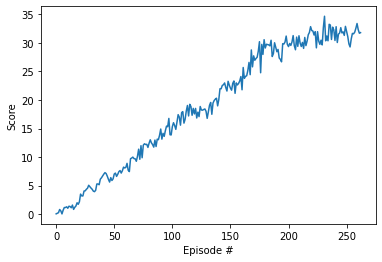

In [18]:
# Create a figure and axis for plotting
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the scores over episodes
plt.plot(np.arange(len(scores)), scores)

# Set labels for the axes
plt.ylabel('Score')
plt.xlabel('Episode #')

# Save the plot as an image file
plt.savefig('ddpg_scores.png', bbox_inches='tight')

# Show the plot
plt.show()

In [8]:
agent = Agents(state_size=state_size, action_size=action_size, random_seed=random_seed)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_20_agents.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_20_agents.pth'))

<All keys matched successfully>

In [9]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
step = 0
while step<1000:
    step+=1
    actions = agent.act(states)                      # select an action
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    rewards = env_info.rewards                   # get the reward
    done = env_info.local_done                  # see if episode has finished
    scores += rewards                                # update the score
    states = next_states                             # roll over the state to next time step
    if np.any(dones):
        break
    
print("Score: {}".format(np.mean(scores)))

Score: 32.60149927129969


In [10]:
env.close()